# Preprocessing

## Imports 

In [2]:
# Task: Import the necessary libraries 

%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

## Inspection

In [3]:
# Task: Define the paths to images and labels

root = Path('Data/Atrium/Task06_Lung/imagesTr/')
label = Path('Data/Atrium/Task06_Lung/labelsTr/')

In [4]:
# Task: Load a sample NIfTI and its corresponding label mask

def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index('imagesTr')] = 'labelsTr'
    return Path(*parts)

sample_path = list(root.glob('lung*'))[3]
sample_path_label = change_img_to_label_path(sample_path)

data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [5]:
# Task: Find out the orientation

nib.aff2axcodes(data.affine)

('L', 'A', 'S')

<IPython.core.display.Javascript object>


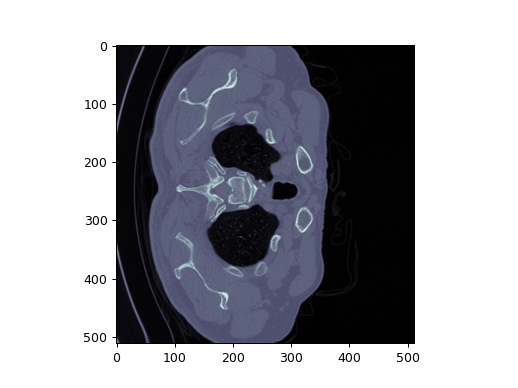

In [6]:
# Task: Inspect the loaded data with overlaid Ground Truth tumor segmentation

from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)

for i in range(0, ct.shape[2], 2):      # AXIAL VIEW
    plt.imshow(ct[:, :, i], cmap='bone')
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5, cmap='autumn');
    camera.snap()
    
animation = camera.animate()

## Preprocessing 

In [8]:
# Task: Please perform the following preprocessing steps:

# 1) CT images have a fixed range from -1000 to 3071. Thus you could normalize by dividing by 3071
# You don't need to compute mean and standard deviation for this task

# 2) As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce 
# the complexity and help the network learn. As an example, you might skip the first 30 slices
# (from lower abdomen to the neck) (last axis)

# 3) As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce
# the computational cost you should store the preprocessed data as 2d files, because reading a single
# slice is much faster than loading the complete NIfTI file.

# 4) Resize the single slices and masks to (256, 256) (when resizing the mask, pass 
# interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

# Loop over all_files and apply the preprocessing steps.

# Additionally, please make sure that all scans have the same orientation

# In the preprocessing loop, you need to create a directory for each subject containg the ct and label slices with identical names.
# E.g:

# 0/data/0.npy
# 0/masks/0.npy
# Store the last 6 subjects as validation data

# PS: Feel free to try the lung window!



all_files = list(root.glob("lung_*"))  # Get all subjects
len(all_files)

63

In [10]:
save_root = Path('Data/Atrium/Task06_Lung/Preprocessed/')

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
    path_to_label = change_img_to_label_path(path_to_ct_data)
    
    ct = nib.load(path_to_ct_data)
    assert nib.aff2axcodes(ct.affine) == ('L', 'A', 'S')
    
    ct_data = ct.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    # skip 30 slices and normalize
    ct_data = ct_data[30:, :, 30:] / 3071
    label_data = label_data[30:, :, 30:]
    
    if counter < 57:
        current_path = save_root / 'train' / str(counter)
    else:
        current_path = save_root / 'val' / str(counter)
    
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:, :, i]
        mask = label_data[:, :, i]
        
        slice_path = current_path / 'data'
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path = current_path / 'masks'
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path / str(i), slice)
        np.save(mask_path / str(i), mask)

  0%|          | 0/63 [00:00<?, ?it/s]

## Validate processed data 

<IPython.core.display.Javascript object>


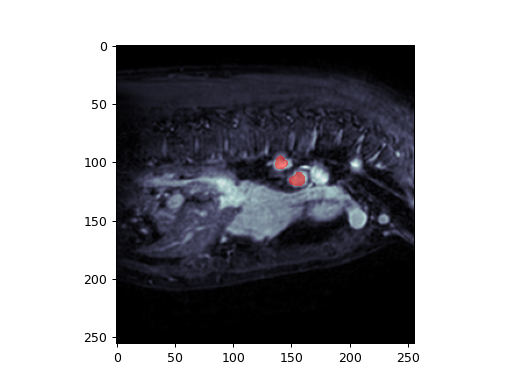

In [13]:
# Task: Take a look at your stored files and inspect if everything worked as expected

path = Path('Data/Atrium/Task02_Heart/Preprocessed/train/0')

file = '101.npy'
slice = np.load(path / 'data' / file)
mask = np.load(path / 'masks' / file)

plt.figure()
plt.imshow(slice, cmap='bone');

mask_ = np.ma.masked_where(mask == 0, mask)

plt.imshow(mask_, alpha=0.5, cmap='autumn');